In [1]:
import numpy as np
from hmmlearn import hmm
import pandas as pd
from torch.utils.data import Dataset
import torch
import seaborn as sns
from pyts.classification import TimeSeriesForest
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import numpy as np
from tsai.all import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, roc_auc_score, f1_score, accuracy_score, classification_report
import sklearn.metrics as skm
from sklearn.preprocessing import StandardScaler
import ruptures as rpt
from utils import *

## Estimate priors

In [2]:
# Load data
tc = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDCE/mdist.csv', delimiter=',')
error_signal = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRN/e.csv',  delimiter=',')
u_signal= np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRN/u.csv',  delimiter=',')

error_signal = error_signal[:,0]
u_signal = u_signal[:,0]
tc = tc[:,0]

# Create feature matrix and labels
scaler = StandardScaler()
error_signal = scaler.fit_transform(error_signal.reshape(-1, 1)).flatten()
u_signal = scaler.fit_transform(u_signal.reshape(-1, 1)).flatten()

error_derivative = np.diff(error_signal)
u_signal_derivative = np.diff(u_signal)

error_derivative = scaler.fit_transform(error_derivative.reshape(-1, 1)).flatten()
u_signal_derivative = scaler.fit_transform(u_signal_derivative.reshape(-1, 1)).flatten()

# Feature matrix X and label vector y
X = np.column_stack((error_signal[:-1], u_signal[:-1], error_derivative, u_signal_derivative))
y = tc[:-1]

mean_vector = np.mean(X, axis=0)

# Compute the covariance matrix
covariance_matrix = np.cov(X, rowvar=False)

## Read data

In [3]:
# Load data
error_signal = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDCE/e.csv',  delimiter=',')
u_signal = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDCE/u.csv',  delimiter=',')

error_signal = error_signal[:,0]
u_signal = u_signal[:,0]

# Create feature matrix and labels
scaler = StandardScaler()
error_signal = scaler.fit_transform(error_signal.reshape(-1, 1)).flatten()
u_signal = scaler.fit_transform(u_signal.reshape(-1, 1)).flatten()

error_derivative = np.diff(error_signal)
u_signal_derivative = np.diff(u_signal)

error_derivative = scaler.fit_transform(error_derivative.reshape(-1, 1)).flatten()
u_signal_derivative = scaler.fit_transform(u_signal_derivative.reshape(-1, 1)).flatten()

# Feature matrix X and label vector y
X = np.column_stack((error_signal[:-1], u_signal[:-1], error_derivative, u_signal_derivative))
y = np.array(tc[:-1], dtype=int)


## Initiate model

In [4]:
# Initialize the HMM with 1 component (only non-distracted state)
model = hmm.GaussianHMM(n_components=2, covariance_type='full', init_params="")

model.startprob_ = np.array([1, 0])
model.transmat_ = np.array([
    [0.99, 0.01],  # High probability of staying in "not distracted"
    [0.2, 0.8]   # High probability of staying in "distracted"
])


# Set the initial mean vector and covariance matrix
model.means_ = np.array([mean_vector, mean_vector])
model.covars_ = np.array([covariance_matrix, covariance_matrix])

# Fit the model on your data (assuming X only contains non-distracted samples)
model.fit(X)

hidden_states = model.predict(X)


In [5]:
# Define the number of states
n_states = 2

# Initialize HMM
model = hmm.GaussianHMM(n_components=n_states, covariance_type='full', init_params="")

# Compute initial probabilities
startprob_init = np.array([np.mean(y == 0), np.mean(y == 1)])

# Compute transition matrix
transitions = np.zeros((n_states, n_states))
for i in range(1, len(y)):
    prev_state = y[i - 1]
    curr_state = y[i]
    transitions[prev_state, curr_state] += 1

# Normalize transition matrix
transmat_init = transitions / transitions.sum(axis=1, keepdims=True)

# Set initial mean vectors and covariance matrices using the labeled data
means_init = np.array([
    X[y == 0].mean(axis=0),  # Mean for state 0
    X[y == 1].mean(axis=0)   # Mean for state 1
])

# Regularization factor
reg_factor = 1e-6

# Covariance matrices for each state with regularization
covars_init = np.array([
    np.cov(X[y == 0], rowvar=False) + np.eye(X.shape[1]) * reg_factor,  # Covariance for state 0
    np.cov(X[y == 1], rowvar=False) + np.eye(X.shape[1]) * reg_factor   # Covariance for state 1
])

# Ensure covariance matrices are symmetric and positive-definite
for i in range(n_states):
    covars_init[i] = (covars_init[i] + covars_init[i].T) / 2  # Make symmetric

# Reshape covars_init to have the correct shape (n_components, n_dim, n_dim)
covars_init = np.array([np.cov(X[y == i], rowvar=False) + np.eye(X.shape[1]) * reg_factor for i in range(n_states)])

# Set the initial parameters
model.startprob_ = startprob_init
model.transmat_ = transmat_init
model.means_ = means_init


model.covars_ = covars_init

# Fit the model on your data
model.fit(X)

# Predict hidden states
hidden_states = model.predict(X)

# Evaluate the model
print("Classification Report:")
print(classification_report(y, hidden_states))

print("Confusion Matrix:")
print(confusion_matrix(y, hidden_states))

print(f"f1 score: {f1_score(y, hidden_states)}")


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.66      0.76      8784
           1       0.46      0.77      0.58      3215

    accuracy                           0.69     11999
   macro avg       0.67      0.72      0.67     11999
weighted avg       0.77      0.69      0.71     11999

Confusion Matrix:
[[5840 2944]
 [ 727 2488]]
f1 score: 0.5754596970047415


## Last try

In [6]:
startprob_init = np.array([1,0])

transitions = np.zeros((n_states, n_states))
for i in range(1, len(y)):
    prev_state = y[i - 1]
    curr_state = y[i]
    transitions[prev_state, curr_state] += 1
transmat_init = transitions / transitions.sum(axis=1, keepdims=True)

means_init = np.array([
    X[y == 0].mean(axis=0),  # Mean for state 0
    X[y == 1].mean(axis=0)   # Mean for state 1
])

# Regularization factor
reg_factor = 1e-6

# Covariance matrices for each state with regularization
covars_init = np.array([
    np.cov(X[y == 0], rowvar=False) + np.eye(X.shape[1]) * reg_factor,  # Covariance for state 0
    np.cov(X[y == 1], rowvar=False) + np.eye(X.shape[1]) * reg_factor   # Covariance for state 1
])

for i in range(n_states):
    covars_init[i] = (covars_init[i] + covars_init[i].T) / 2


model.startprob_ = startprob_init
model.transmat_ = transmat_init
model.means_ = means_init
model.covars_ = covars_init

# Fit the model on the data
model.fit(X)
hidden_states = model.predict(X)


# Evaluate the model
print("Classification Report:")
print(classification_report(y, hidden_states))

print("Confusion Matrix:")
print(confusion_matrix(y, hidden_states))


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76      8784
           1       0.46      0.77      0.58      3215

    accuracy                           0.69     11999
   macro avg       0.67      0.72      0.67     11999
weighted avg       0.77      0.69      0.71     11999

Confusion Matrix:
[[5842 2942]
 [ 727 2488]]


In [7]:
# Initialize and fit the HMM on non-distracted data
model = hmm.GaussianHMM(n_components=2, covariance_type='full', init_params="")

model.startprob_ = startprob_init
model.transmat_ = transmat_init
model.means_ = means_init
model.covars_ = covars_init

X_non_distracted = X[y == 0]
model.fit(X)

# Predict hidden states on mixed data
hidden_states_mixed = model.predict(X)

# Evaluate the model
print("Classification Report:")
print(classification_report(y, hidden_states_mixed))

print("Confusion Matrix:")
print(confusion_matrix(y, hidden_states_mixed))

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76      8784
           1       0.46      0.77      0.58      3215

    accuracy                           0.69     11999
   macro avg       0.67      0.72      0.67     11999
weighted avg       0.77      0.69      0.71     11999

Confusion Matrix:
[[5842 2942]
 [ 727 2488]]


## Test data

pred_labels.shape=(11999,); true_labels.shape=(11999,)
FP.shape=(11999,); time_axis.shape=(11999,); true_labels.shape=(11999,)


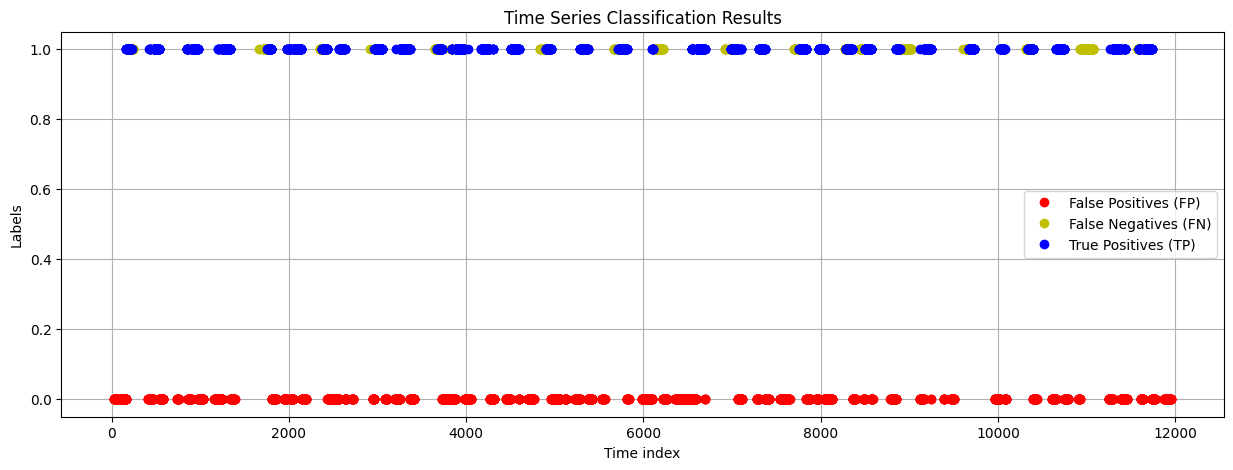

In [8]:
def plot_intermediary_results(pred_labels, true_labels):
    
    pred_labels = np.ravel(pred_labels)
    true_labels = np.ravel(true_labels)
   
    TN = (pred_labels == 0) & (true_labels == 0)
    FP = (pred_labels == 1) & (true_labels == 0)
    FN = (pred_labels == 0) & (true_labels == 1)
    TP = (pred_labels == 1) & (true_labels == 1)

    time_axis = np.arange(len(true_labels))

    plt.figure(figsize=(15, 5))
    
    print(f"{pred_labels.shape=}; {true_labels.shape=}")
    print(f"{FP.shape=}; {time_axis.shape=}; {true_labels.shape=}")

    # Plot False Positives (FP)
    plt.plot(time_axis[FP], true_labels[FP], 'ro', label="False Positives (FP)")

    # Plot False Negatives (FN)
    plt.plot(time_axis[FN], true_labels[FN], 'yo', label="False Negatives (FN)")

    # Plot True Positives (TP)
    plt.plot(time_axis[TP], true_labels[TP], 'bo', label="True Positives (TP)")

    plt.xlabel("Time index")
    plt.ylabel("Labels")
    plt.grid()
    plt.title("Time Series Classification Results")
    plt.legend()
    plt.show()

# Plot results
plot_intermediary_results(hidden_states, y)

In [9]:
# Compute accuracy
accuracy = accuracy_score(y, hidden_states)
print(f"Accuracy: {accuracy:.4f}")

# Compute F1 Score (considering binary classification)
f1 = f1_score(y, hidden_states, average='binary')
print(f"F1 Score: {f1:.4f}")

# Optionally, if you have more detailed classification metrics
from sklearn.metrics import classification_report

report = classification_report(y, hidden_states, target_names=['Not Distracted', 'Distracted'])
print("\nClassification Report:")
print(report)

Accuracy: 0.6942
F1 Score: 0.5756

Classification Report:
                precision    recall  f1-score   support

Not Distracted       0.89      0.67      0.76      8784
    Distracted       0.46      0.77      0.58      3215

      accuracy                           0.69     11999
     macro avg       0.67      0.72      0.67     11999
  weighted avg       0.77      0.69      0.71     11999

